In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_palette
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set_palette(flatui)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.25
plt.rcParams['grid.alpha'] = 0.2
plt.style.use('seaborn-talk')

from IPython.display import Audio

In [2]:
# Microphone positions
pos_x = np.arange(-0.8, 0.8+1e-6, 0.2)
n_mics = len(pos_x)
pos_y = np.zeros(n_mics)
pos_z = np.zeros(n_mics)
mic_pos = np.row_stack((pos_x, pos_y, pos_z))

In [3]:
SOUND_SPEED = 340 # [m/s]
sampling_frequency = 44000 # [Hz]
n_fft = 512
i_frequency = 9
frequency = i_frequency / n_fft * sampling_frequency
print(frequency)

773.4375


In [4]:
# Source angles
theta_s = np.array([-10, 5, 30]) # [degree]
phi_s = np.array([0, 0, 0]) # [degree]

In [5]:
theta_grid = np.arange(-90, 90+1e-6, 0.1) # [degree]
phi_grid = np.array([0]) # [degree]

# Steering vectors
def compute_steering_vectors_single_frequency(mic_pos, frequency, theta_grid, phi_grid):
    # wave number
    k = 2*np.pi*frequency/SOUND_SPEED

    n_mics = len(mic_pos[0])
    theta_grid = theta_grid * np.pi/180 # [degree] to [radian]
    phi_grid = phi_grid * np.pi/180 # [degree] to [radian]
    
    u = np.sin(theta_grid.reshape(-1, 1)).dot(np.cos(phi_grid).reshape(1, -1))
    v = np.sin(theta_grid.reshape(-1, 1)).dot(np.sin(phi_grid).reshape(1, -1))
    w = np.tile(np.cos(theta_grid.reshape(-1, 1)), (1, phi_grid.shape[0]))

    x = u.reshape(u.shape[0], u.shape[1], 1)*mic_pos[0].reshape(1, 1, n_mics)
    y = v.reshape(v.shape[0], v.shape[1], 1)*mic_pos[1].reshape(1, 1, n_mics)
    z = w.reshape(w.shape[0], w.shape[1], 1)*mic_pos[2].reshape(1, 1, n_mics)

    return np.exp( 1j*k*(x + y + z))

def compute_steering_vectors(mic_pos, sampling_frequency, n_fft, theta_grid, phi_grid):
    n_thetas = len(theta_grid)
    n_phis = len(phi_grid)
    n_mics = len(mic_pos[0])
    steering_vectors = np.zeros((n_fft, n_thetas, n_phis, n_mics), dtype=np.complex64)
    for i_fft in range(n_fft):
        frequency = (i_fft / n_fft) * sampling_frequency
#         if i_fft == i_frequency:
#             print("i_frequency {}  frequency {}".format(i_frequency, frequency))
        steering_vectors[i_fft] = compute_steering_vectors_single_frequency(mic_pos, frequency, theta_grid, phi_grid)
    return steering_vectors

In [6]:
steering_vectors = compute_steering_vectors(mic_pos, sampling_frequency=sampling_frequency, 
                                    n_fft=n_fft, theta_grid=theta_grid, phi_grid=phi_grid)
v = compute_steering_vectors_single_frequency(mic_pos, frequency, theta_grid, phi_grid)
np.linalg.norm(steering_vectors[i_frequency][:, 0, :] - v[:, 0, :])


2.527434571469098e-06

In [7]:
# Delay-sum beamformer
source_steering_vectors = compute_steering_vectors(mic_pos, sampling_frequency, n_fft, 
    np.array([theta_s[0]]), np.array([phi_s[0]]))
ds_beamformer = 1./n_mics * source_steering_vectors[i_frequency]
v = compute_steering_vectors_single_frequency(mic_pos, frequency, np.array([theta_s[0]]), np.array([phi_s[0]]))
np.linalg.norm(source_steering_vectors[i_frequency][0, 0, :] - v[0, 0, :])

5.151173118012857e-08

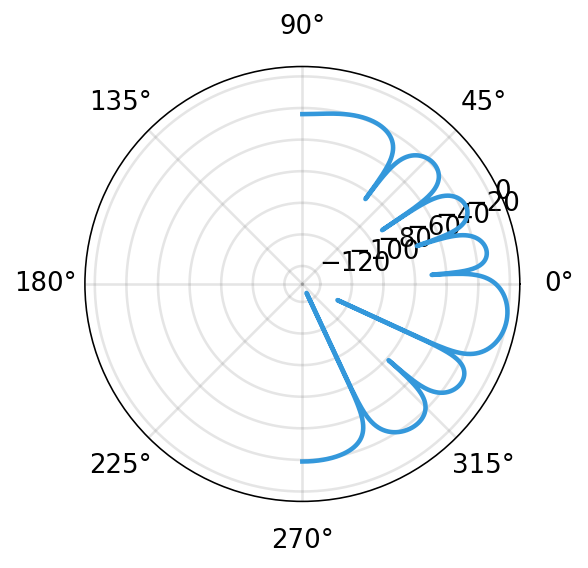

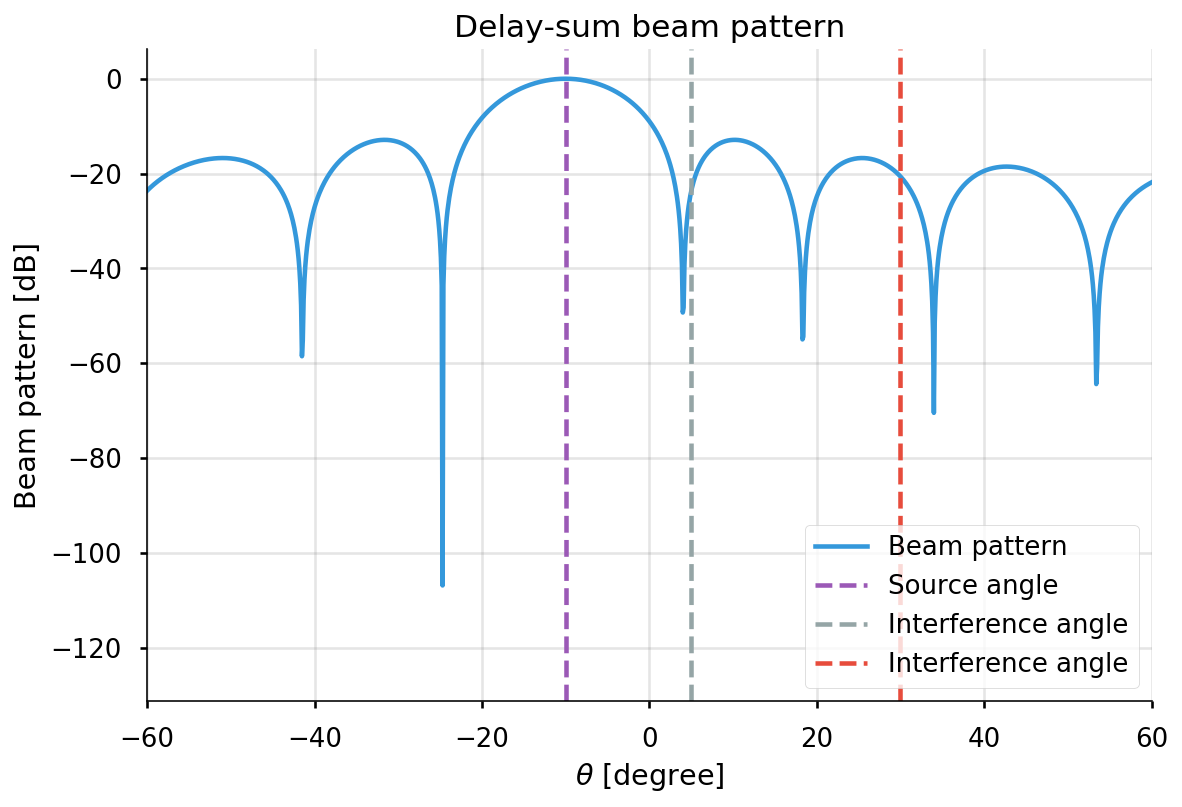

In [8]:
ds_beampattern = np.sum(ds_beamformer.conjugate() * steering_vectors[i_frequency], axis=2)
fig = plt.figure(); ax = fig.add_subplot(111, polar=True)
ax.plot(theta_grid*np.pi/180, 20*np.log10(np.abs(ds_beampattern[:, 0])));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, 20*np.log10(np.abs(ds_beampattern[:, 0])), label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-60, 60);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Delay-sum beam pattern");
ax.legend();

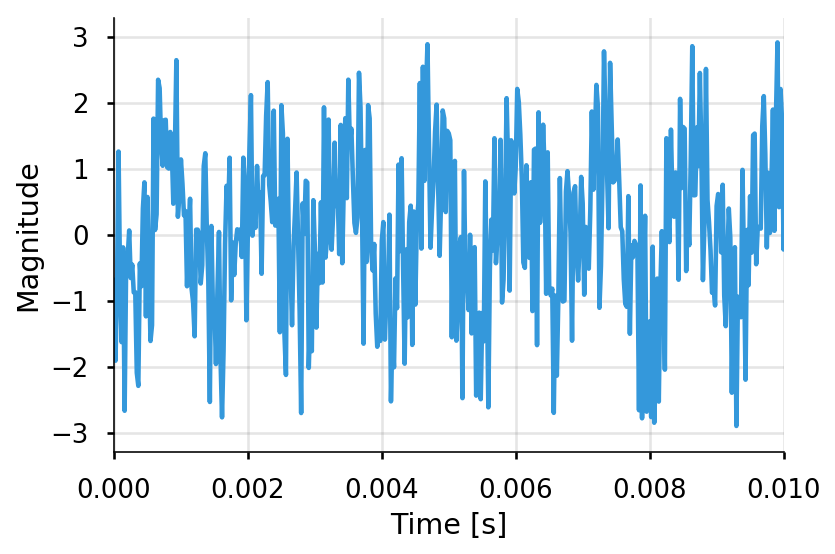

In [9]:
# Generate signal
duration = 44000/sampling_frequency # [s]
n_samples = int(np.floor(duration * sampling_frequency))
time_samples = np.arange(0, duration - 1/sampling_frequency, 1/sampling_frequency)
amplitudes = np.zeros(theta_s.shape)
signal = np.zeros((n_mics, n_samples), dtype=np.complex64)
interference = np.zeros((n_mics, n_samples), dtype=np.complex64)
np.random.seed(0)
for i_angle in range(len(theta_s)):
    doa = ( compute_steering_vectors(mic_pos, sampling_frequency, n_fft, np.array([theta_s[i_angle]]),
                           np.array([phi_s[i_angle]])) )[i_frequency, 0, 0, :]
    doa_check = ( compute_steering_vectors_single_frequency(mic_pos, frequency, 
                    np.array([theta_s[i_angle]]), np.array([phi_s[i_angle]])) )[0, 0, :]

    if i_angle == 0:
        signal += 10**(amplitudes[i_angle]/20)*doa.reshape([-1, 1])*\
                np.exp( 1j*2*np.pi*( frequency*time_samples.reshape([1, -1]) \
                        + 0*np.random.randn(1, n_samples)))
    else:
        s = 10**(amplitudes[i_angle]/20)*doa.reshape([-1, 1])*\
                            np.exp( 1j*2*np.pi*( frequency*time_samples.reshape([1, -1]) \
                            + 1*np.random.randn(1, n_samples)))
        interference += s
    
        signal += s 

# Sample covariance matrix    
sample_covariance_matrix = 1./n_samples * ( signal.dot(signal.transpose().conjugate()) + 100*np.identity(n_mics) )
inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
interference_R = 1./n_samples * ( interference.dot(interference.transpose().conjugate()) + 100*np.identity(n_mics) )
interference_inverse_R = np.linalg.inv(interference_R)

fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(time_samples, signal[0].real);
ax.set_xlim([0, 0.01]); ax.set_xlabel("Time [s]"); ax.set_ylabel("Magnitude");

Audio(np.real(signal[0]), rate=sampling_frequency, autoplay=True)

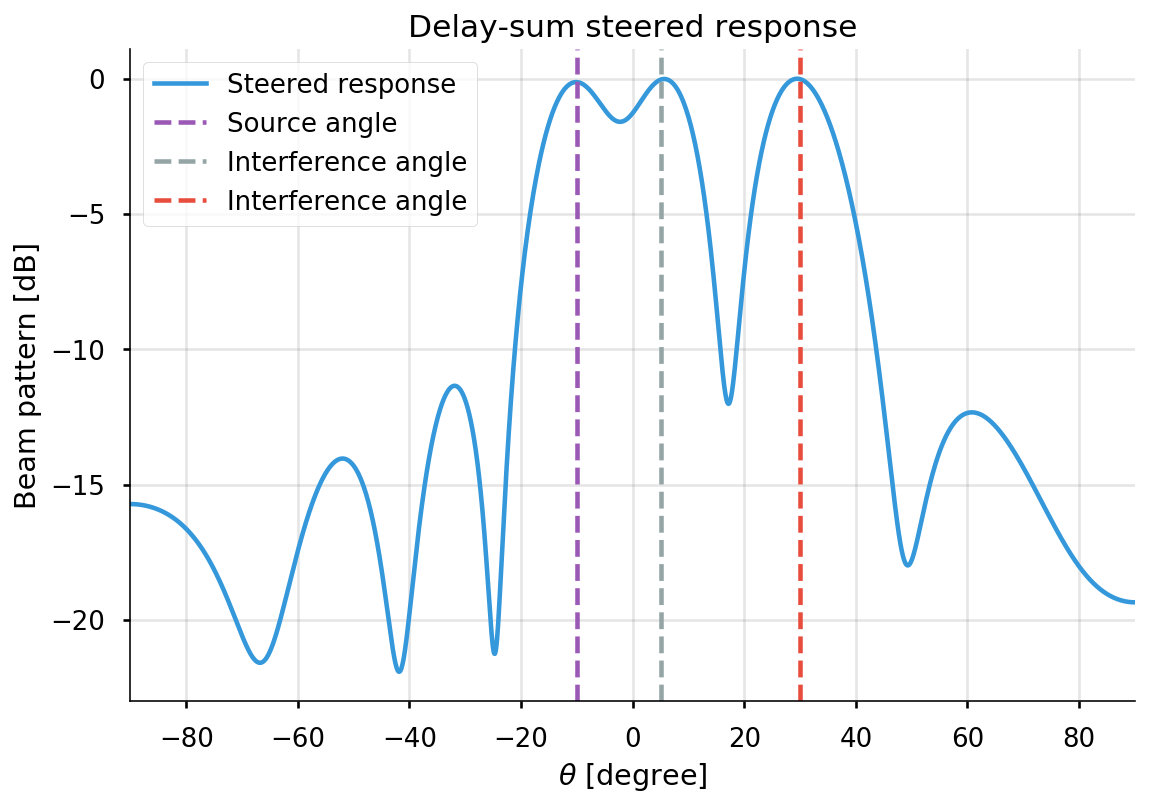

In [10]:
# Delay-sum steered response
ds_S = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_theta in range(len(theta_grid)):
    for i_phi in range(len(phi_grid)):
        scanning_steering_vector = steering_vectors[i_frequency][i_theta][i_phi]
        ds_S[i_theta][i_phi] = (1./n_mics * scanning_steering_vector).transpose().conjugate().dot(
            sample_covariance_matrix).dot(1./n_mics * scanning_steering_vector)

ds_S_normalized = np.abs(ds_S)/np.max(np.abs(ds_S))
ds_S_db = 10*np.log10(ds_S_normalized);
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, ds_S_db[:, 0], label="Steered response");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Delay-sum steered response")
ax.legend();

In [11]:
# MVDR beamformer
normalization_factor = source_steering_vectors[i_frequency, 0, 0, :].transpose().conjugate().dot(
    interference_inverse_R).dot(
    source_steering_vectors[i_frequency, 0, 0, :])
mvdr_beamformer = interference_inverse_R.dot(source_steering_vectors[i_frequency, 0, 0, :]) / normalization_factor

# MPDR beamformer
normalization_factor = source_steering_vectors[i_frequency, 0, 0, :].transpose().conjugate().dot(inverse_sample_covariance_matrix).dot(source_steering_vectors[i_frequency, 0, 0, :])
mpdr_beamformer = inverse_sample_covariance_matrix.dot(source_steering_vectors[i_frequency, 0, 0, :]) / normalization_factor
v = source_steering_vectors[i_frequency, 0, 0, :]
f = v.transpose().conjugate().dot(interference_inverse_R).dot(v)
b = interference_inverse_R.dot(v) / f

[-10   4   5   6  29  30  31]


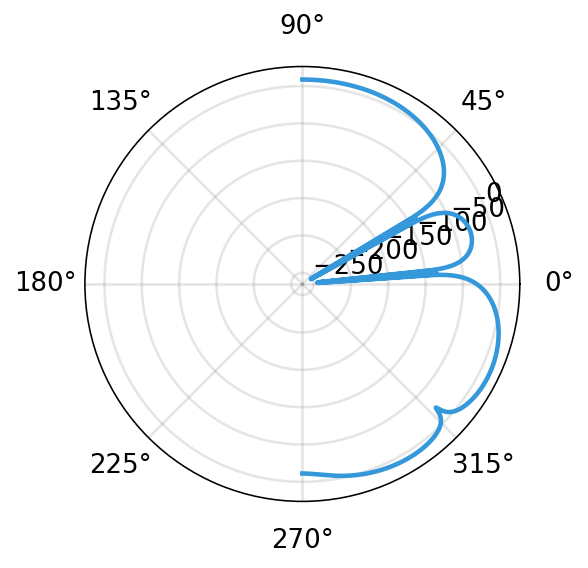

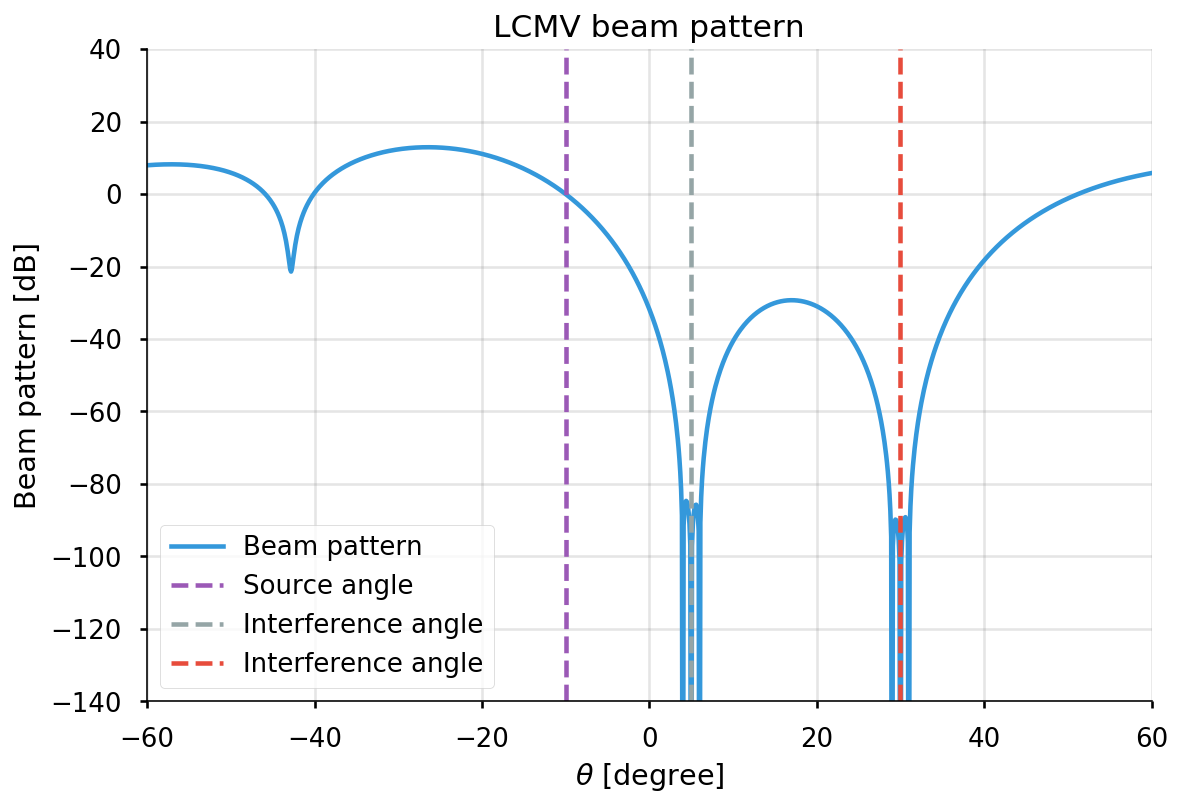

In [13]:
def compute_lcmv_beamformer(steering_vectors, signal, constraint_vector):
    n_mics, n_samples = signal.shape
    sample_covariance_matrix = 1./1 * ( signal.dot(signal.transpose().conjugate()) + 1*np.identity(n_mics) )
    inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
    normalization_matrix = steering_vectors.transpose().conjugate().dot(
        inverse_sample_covariance_matrix).dot(
        steering_vectors)
    inverse_normalization_matrix = np.linalg.inv(normalization_matrix)
    weight = inverse_sample_covariance_matrix.dot(steering_vectors).dot(
        inverse_normalization_matrix).dot(constraint_vector)
    return weight
# LCMV beamformer
# theta_lcmv = np.array([-10, 5, 26, 28, 30, 32]) # [degree]
# phi_lcmv = np.zeros(1) # [degree]
# constraint_vector = np.array([1, 0, 0, 0, 0, 0])

# theta_nulling = np.array([3, 5, 7, 30])
theta_nulling = np.array([4, 5, 6, 29, 30, 31])
theta_lcmv = np.hstack((theta_s[0], theta_nulling))
phi_lcmv = np.zeros([1])
lcmv_constraint_vector = np.zeros(theta_nulling.shape[0] + 1)
lcmv_constraint_vector[0] = 1
print(theta_lcmv)
C = compute_steering_vectors(mic_pos, sampling_frequency, n_fft, 
    theta_lcmv, phi_lcmv)[i_frequency, :, 0, :].transpose()
np.linalg.norm(source_steering_vectors[i_frequency][0, 0, :].reshape(9, 1) - C)
lcmv_beamformer = compute_lcmv_beamformer(C, interference, lcmv_constraint_vector)

# LCMV beampattern
lcmv_beampattern = np.sum(lcmv_beamformer.reshape(1, 1, -1).conjugate() * steering_vectors[i_frequency], axis=2)
fig = plt.figure(); ax = fig.add_subplot(111, polar=True)
ax.plot(theta_grid*np.pi/180, 20*np.log10(np.abs(lcmv_beampattern[:, 0])));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, 20*np.log10(np.abs(lcmv_beampattern[:, 0])), label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-60, 60); ax.set_ylim([-140, 40])
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("LCMV beam pattern");
ax.legend();

In [ ]:
mvdr_beampattern = np.sum(mvdr_beamformer.reshape(1, 1, -1).conjugate() * steering_vectors[i_frequency], axis=2)
fig = plt.figure(); ax = fig.add_subplot(111, polar=True)
ax.plot(theta_grid*np.pi/180, 20*np.log10(np.abs(mvdr_beampattern[:, 0])));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, 20*np.log10(np.abs(mvdr_beampattern[:, 0])), label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-60, 60);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("MVDR beam pattern");
ax.legend();
mvdr_beampattern.shape

In [ ]:
mpdr_beampattern = np.sum(mpdr_beamformer.reshape(1, 1, -1).conjugate() * steering_vectors[i_frequency], axis=2)
fig = plt.figure(); ax = fig.add_subplot(111, polar=True)
ax.plot(theta_grid*np.pi/180, 20*np.log10(np.abs(mpdr_beampattern[:, 0])));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, 20*np.log10(np.abs(mpdr_beampattern[:, 0])), label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-60, 60);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("MPDR beam pattern");
ax.legend();

In [ ]:
# Delay-sum steered response
mvdr_S = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_theta in range(len(theta_grid)):
    for i_phi in range(len(phi_grid)):
        scanning_steering_vector = steering_vectors[i_frequency][i_theta][i_phi]
        mvdr_S[i_theta][i_phi] = 1. / ( scanning_steering_vector.transpose().conjugate().dot(inverse_sample_covariance_matrix).dot(scanning_steering_vector))

mvdr_S_normalized = np.abs(mvdr_S)/np.max(np.abs(mvdr_S))
mvdr_S_db = 10*np.log10(mvdr_S_normalized);
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, mvdr_S_db[:, 0], label="MVDR");
ax.plot(theta_grid, ds_S_db[:, 0], label="Delay-sum")
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[2], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+2], label="Interference angle");
ax.set_xlim(-60, 60);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Beam pattern [dB]");
ax.set_title("Steered response")
ax.legend();

In [ ]:
out = mvdr_beampattern * mvdr_S
out_db = 10*np.log10(out);
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, out_db[:, 0], label="Steered response");

In [ ]:
ds_out = ds_beamformer[0, 0, :].transpose().conjugate().dot(signal)
Audio(np.real(ds_out), rate=sampling_frequency, autoplay=True)

In [ ]:
mpdr_out = mpdr_beamformer.transpose().conjugate().dot(signal)
Audio(np.real(mpdr_out), rate=sampling_frequency, autoplay=True)

In [ ]:
mvdr_out = mvdr_beamformer.transpose().conjugate().dot(signal)
Audio(np.real(mvdr_out), rate=sampling_frequency, autoplay=True)

In [ ]:
lcmv_out = lcmv_beamformer.transpose().conjugate().dot(signal)
Audio(np.real(lcmv_out), rate=sampling_frequency, autoplay=True)